# Employee Turnover Prediction

# Impetus

In my organization, we are seeing what appears to be an increase in employee turnover in recent years. This may be a byproduct of increased size, employees aging, or other market factors. In order to determine some of the primary reasons for employee turnover, I will be exploring multiple machine learning models to see which can best predict employees that either have left the company, or those that are similar to employees that have left.  

One of the primary reasons for determining the employees at highest risk for turnover is to predict the potential impact of turnover on production metrics. Of course, this also requires some testing to see exactly how turnover affects production metrics, as currently no one has done this analysis. In effect, Human Resources would like to know who are high risk for turnover, and what impact such turnover may produce.  

In addition to the information collected from our data warehouse and payroll provider, I will also be including market factors in this analysis. In light of the current COVID-19 crisis (writing this paper as of late March 2020), it is clear that internal factors are not the only potentially influential variables. In order to attempt to capture the state of the US economy in simple terms, I will be collecting macro-economic indices and seeing which ones have the greatest impact. This will require some munging to add to the employee data in a cohesive manner, but may add a new layer to the analysis. 

# Data

## Employee Data

This data set is the primary component of this analysis. This table contains information for employees throughout the history of the organization. I have been informed that it should include all employees over this time span, but this claim appears dubious as there are many missing employee ID numbers that should be present in this set (for instance, employees 17 and 19 exist, but 18 does not). There have been a couple large changes in the ID field, namely a move from integers increasing from 1, to a period in which new employees started at 3000 and temporary employees were started at 9000. I am not privy to the design decision behind this, but it is worth noting.  

In addition to the potential of missing employee records, there are many fields which are not fully maintained. Fields such as address, birthday, and department do not appear to be maintained. These fields will be removed during the ETL and exploration phases. In addition, we will be altering the termination date to fall on the first day of the month in which it occurred so we can more easily combine with subsequent data sets.

## Production Data

This granular data set was pulled from our data warehouse (SQL Server, change tracking used to maintain integrity with the production ERP system), and is intended to be used to demonstrate the efficacy of our assembly group. This data contains all production orders since the implementation of Navision (our ERP system, now owned by Microsfot and renamed Dynamics) in the 2000s. This data is far too granular to be useful in this analysis, so we will be aggregating by month and splitting into a couple groups (based on the days before, on, or after the due date). This will give a high level view as to the state of production at any given month.

The existing hypothesis is that the higher the turnover in a period, the higher the production impact in the same period, or in a lagged period (perhaps the next month, or 2 months post). There are 2 variants which will be analyzed: the proportion of lines by days past due or early (volume of product) and the proportion of run time by days past due or early (production time). By making both of these values proportional, we remove the bias that may occur as growth increases both values over time. Each of these values return slightly different figures, as I have already prepared a live report in Power BI that does something incredibly similar and it is apparent that they differ ever so slighly over time.

## Shipment Data

This data set is also taken from our data warehouse and is an atomic view of all our shipment lines since Navision implementation. Just like the production data, this table is far too granular for our needs, and will be aggreagated to the same monthly grain. On thing to consider in this component of the analysis may also be looking at 2 factors, just like the production data. For shipments, instead of looking at line count and run time, we will be analyzing line count (number of individual shipment lines, not combined truckloads) and the shipment value (the value of the product, not 100% the same as the recognized revenue, but very close).

The hypothesis for this data set is the same as production, namely, if turnover is high, then shipments will suffer (either now or lagged).

## Salary data

Unfortunately, while attempting to capture additional data for employee salary, I have been barred from using it in this analysis. We certainly retain this information, but our Human Resources department was not comfortable allowing access to this data, even if all personal information was obscurred and not included in the available files for this analysis. As such, I have also dropped my work to capture salary data for the United States. The intention was to compare an employee's salary to that of Americans with the same job title. This was going to be difficult to analyze as we would only be able to capture current salary statistics for the US, so employees that are already terminated would have had to be  adjusted to current day dollars using CPI. Unfortunately, for the time being this component must be dropped.

## Market Indices

The outbreak and subsequent market collapse due to the COVID-19 virus has opened up a new component to consider in this analysis: the health of the market at the time of termination. At first this was not considered, as market conditions were healthy and the impact of a recession had not passed my mind. In order to guage the health of the market, a couple factors will be considered:
* GDP growth at time of termination (described further in ETL section)
* CPI at time of termination (described further in ETL section)
* DOW Jones Industrial Average growth at time of termination (described further in ETL section)

This figures will be adjusted to match the monthly level that we see in the production and shipment data sets. This should assist in simplifying the model building and reduce both cardinality and size.

# ETL 

## Employee Data

First, we must pull the data from our data warehouse. This query is very simple and had a couple fields removed in order to reduce the number of variables.

### Query from SQL Server instance

SELECT [No_]
	,[First Name]
	,[Middle Name]
	,[Last Name]
	,[Initials]
	,[Job Title]
	,[Search Name]
	,[Address]
	,[Address 2]
	,[City]
	,[Post Code]
	,[County]
	,[Phone No_]
	,[Mobile Phone No_]
	,[E-Mail]
	,[Alt_ Address Code]
	,[Alt_ Address Start Date]
	,[Alt_ Address End Date]
	,[Birth Date]
	,[Union Code]
	,[Sex]
	,[Manager No_]
	,[Emplymt_ Contract Code]
	,[Employment Date]
	,[Status]
	,[Inactive Date]
	,[Cause of Inactivity Code]
	,[Termination Date]
	,[Grounds for Term_ Code]
	,[Global Dimension 1 Code]
	,[Global Dimension 2 Code]
	,[Resource No_]
	,[Last Date Modified]
	,[Extension]
	,[Company E-Mail]
	,[Title]
	,[Salespers__Purch_ Code]
	,[Difference Time Recording]
	,[Difference BDE]
	,[Difference Posted Capacities]
	,[Punch Clock Card No_]
	,[Department]
	,[Employee No_]
	,[Building Code]
	,[Floor Code]
	,[Speed Dial]
	,[Speed Dial Mobile Phone]
	,[Not in Phone List]
	,[Base Calendar Code]
	,[Global Attendance Time]
	,[Race]
	,[Position Code]
	,[Blocked]
	,[Middle Initial]
	,[Default Work Type Code]
	,[Salaried]
	,[Beginning BTO]
  FROM XXX

  This query was then saved as an XLSX file in order to transport from company systems to the analysis system (personal machine). This was then imported into the Jupyter Notebook as a Pandas dataframe.

In [1]:
#Import into Jupyter

import pandas as pd

emp = pd.read_excel('G:\Shared drives\Sale\Escuela\Elmhurst_MSDS\MDS_564_adv._data_mining_and_analytics\ProjectData\Emps.xlsx')

In [2]:
#View dataframe

emp.head(5)

,No_,First Name,Middle Name,Last Name,Initials,Job Title,Search Name,Address,Address 2,City,...,Base Calendar Code,Global Attendance Time,Race,Position Code,Blocked,Middle Initial,Default Work Type Code,Salaried,Beginning BTO,Employment Days
0,717,Ryan,NaN,Day,NaN,Assembly casual,DAY,NaN,NaN,NaN,...,US,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.000,39.0
1,725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43918.0
2,107,Ron,NaN,Randall,NaN,Sub-Assembler,RANDALL,NaN,NaN,NaN,...,US,0.0,NaN,NaN,0.0,NaN,NaN,0.0,2.318,14526.0
3,1077,Jim,NaN,Bronsema,jjbron,Distributor Sales Director,BRONSEMA,NaN,NaN,NaN,...,US,0.0,NaN,NaN,0.0,j,NaN,0.0,0.000,15726.0
4,110,Joseph,NaN,McDaniel,NaN,Receiving Clerk 1300,MCDANIEL,NaN,NaN,NaN,...,US,0.0,NaN,NaN,0.0,NaN,NaN,0.0,35.876,14800.0


In [3]:
#Convert data types

emp['Employment Date'] = pd.to_datetime(emp['Employment Date'])

emp['Inactive Date'] = pd.to_datetime(emp['Inactive Date'])

In [4]:
#Remove fields with all nulls or nearly all nulls, as well as redundant variables

emp = emp.drop(columns=['First Name','Middle Name','Last Name','Initials','Search Name','Address','Address 2','City','Post Code','County','Phone No_','Mobile Phone No_','E-Mail','Alt_ Address Code','Alt_ Address Start Date','Alt_ Address End Date','Emplymt_ Contract Code','Resource No_','Last Date Modified','Extension','Company E-Mail','Difference Time Recording','Difference BDE','Difference Posted Capacities','Punch Clock Card No_','Speed Dial','Speed Dial Mobile Phone','Not in Phone List','Position Code','Middle Initial','Default Work Type Code','Department','Employee No_','Birth Date','Union Code','Sex','Race','Title','Global Dimension 2 Code','Global Attendance Time','Termination Date'])

In [5]:
#Rename certain fields for greater readability

emp = emp.rename(columns = {'Global Dimension 1 Code': 'Department', 'Grounds for Term_ Code' : 'Termination Reason'})

In [6]:
#Create a new column for classification

term_date = pd.to_datetime('01/01/1900')

emp['Terminated'] = emp['Inactive Date'].apply(lambda x: 1 if x > term_date else 0)

In [7]:
#Add a length of employment field for years

emp['Length of Employment'] = emp['Employment Days'] / 365

In [8]:
#Remove rows with no Employment Date

emp = emp.dropna(subset = ['Employment Date'])

In [9]:
#Alter Inactive Date to be considered on the last of the month

from pandas.tseries.offsets import MonthEnd

emp['Inactive Month'] = pd.to_datetime(emp['Inactive Date'], format = '%Y%m') + MonthEnd(1)

In [10]:
#View dataframe

emp.head(5)

,No_,Job Title,Manager No_,Employment Date,Status,Inactive Date,Cause of Inactivity Code,Termination Reason,Department,Salespers__Purch_ Code,Building Code,Floor Code,Base Calendar Code,Blocked,Salaried,Beginning BTO,Employment Days,Terminated,Length of Employment,Inactive Month
0,717,Assembly casual,3486,2020-02-18,0.0,NaT,NaN,NaN,D040,NaN,1300,1ST,US,0.0,0.0,0.000,39.0,0,0.106849,NaT
2,107,Sub-Assembler,473,1979-08-28,1.0,2019-06-05,RETIRED,NaN,D040,NaN,MAIN,SHOP,US,0.0,0.0,2.318,14526.0,1,39.797260,2019-06-30
3,1077,Distributor Sales Director,3436,1977-03-08,0.0,NaT,NaN,NaN,D185,NaN,1300,2ND,US,0.0,0.0,0.000,15726.0,0,43.084932,NaT
4,110,Receiving Clerk 1300,NaN,1979-09-20,0.0,NaT,NaN,NaN,D050,NaN,1300,SHOP,US,0.0,0.0,35.876,14800.0,0,40.547945,NaT
5,111,Roller Tube Cut Off,59,1979-09-17,0.0,NaT,NaN,NaN,D015,NaN,1210,SHOP,US,0.0,0.0,7.497,14803.0,0,40.556164,NaT


## Production Data

Production data is stored on a production order level and contains some calculations to see how on-time, early, or late the productions are compared to their due dates. These values will be calculated and bounded to shrink the table, and then will be aggregated on a monthly grain. The resulting proportion will be used in the modeling process.

In [11]:
#Import into Jupyter

prods = pd.read_csv('G:\Shared drives\Sale\Escuela\Elmhurst_MSDS\MDS_564_adv._data_mining_and_analytics\ProjectData\Prods.csv', names = ['Prod_ Order No_', 'Status', 'Line No_', 'Item No_', 'Sales Order No_', 'Segment', 'Sales Order Key', 'Variant Code', 'Description', 'Finished Quantity', 'Ending Date', 'Ending Date Modifier', 'Modified Ending Date', 'Due Date', 'Work Center No_', 'Destination', 'Total Run Time', 'Putaway Date'])

In [12]:
#Remove uneeded columns

prods = prods.drop(columns = ['Status', 'Item No_', 'Sales Order No_', 'Segment', 'Sales Order Key', 'Variant Code', 'Description', 'Finished Quantity', 'Ending Date', 'Ending Date Modifier', 'Due Date', 'Work Center No_', 'Destination'])

In [13]:
#Filter out production order lines that do not have a correct dates (if missing, then an error occurred)

prods = prods.dropna(subset = ('Modified Ending Date', 'Putaway Date'))

In [14]:
#Convert date types

prods['Modified Ending Date'] = pd.to_datetime(prods['Modified Ending Date'])

prods['Putaway Date'] = pd.to_datetime(prods['Putaway Date'])

In [15]:
#Add a new calculated column, removing weekend dates (non-working days)

import numpy as np
import datetime as dates

mod_date = [d.date() for d in prods['Modified Ending Date']]
put_date = [d.date() for d in prods['Putaway Date']]

prods['Days Past Due'] = np.busday_count(mod_date, put_date)

In [16]:
#Cap the column values for simplicity

prods['Capped Days'] = prods['Days Past Due']
prods.loc[prods['Days Past Due'] >= 3, 'Capped Days'] = 3
prods.loc[prods['Days Past Due'] <= -3, 'Capped Days'] = -3

In [17]:
#Add a monthly date to group the lines on

prods['Putaway Month'] = pd.to_datetime(prods['Putaway Date'], format = '%Y%m') + MonthEnd(1)

In [18]:
#Group production orders by date and capped days, calculate the count of line and sum of run time, convert to proportion, then pivot to month level

prods_count = prods.groupby(['Putaway Month', 'Capped Days'])['Line No_'].count()
prods_count_perc = prods_count.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

prods_time = prods.groupby(['Putaway Month', 'Capped Days'])['Total Run Time'].sum()
prods_time_perc = prods_time.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

In [19]:
#Pivot grouped tables

prod_count_piv = prods_count_perc.pivot(index = 'Putaway Month', columns = 'Capped Days', values = 'Line No_')

prod_time_piv = prods_time_perc.pivot(index = 'Putaway Month', columns = 'Capped Days', values = 'Total Run Time')

In [20]:
#View count pivot

prod_count_piv.head(5)

Capped Days,-3,-2,-1,0,1,2,3
Putaway Month,,,,,,,
2009-02-28,0.223714,0.223714,0.223714,3.355705,12.304251,16.331096,67.337808
2009-03-31,NaN,NaN,NaN,1.605136,6.340289,10.513644,81.540931
2009-04-30,7.404580,3.435115,0.152672,2.137405,7.099237,22.748092,57.022901
2009-05-31,NaN,3.522013,1.635220,6.289308,12.830189,25.408805,50.314465
2009-06-30,NaN,NaN,3.687943,11.205674,17.872340,20.851064,46.382979


In [21]:
#View run time pivot 

prod_time_piv.head(5)

Capped Days,-3,-2,-1,0,1,2,3
Putaway Month,,,,,,,
2009-02-28,0.265190,0.059226,0.030055,2.167485,3.990665,10.503286,82.984093
2009-03-31,NaN,NaN,NaN,1.460523,5.469084,8.183708,84.886685
2009-04-30,5.222465,2.400615,0.080594,2.062659,4.519420,19.069251,66.644996
2009-05-31,NaN,2.554359,1.460408,4.024064,10.809345,19.573731,61.578093
2009-06-30,NaN,NaN,1.589021,9.460258,11.327796,13.411471,64.211454


## Shipment Line Data

The shipment line data is very similar in scope to the production order data, save for the fact that we will be considering the sales value rather than the run time. The same steps applied in the production data will be applied to the sales line data to get a monthly pivot for both the count and the sum.

In [22]:
#Import into Jupyter

ships = pd.read_csv('G:\Shared drives\Sale\Escuela\Elmhurst_MSDS\MDS_564_adv._data_mining_and_analytics\ProjectData\Ships.csv', names = ['Document No_','Line No_','Sell-to Customer No_','Type','No_','Location Code','Posting Group','Shipment Date','Description','Unit of Measure','Quantity','Unit Price','Unit Cost (LCY)','VAT %','Line Discount %','Invoiced Amount','Qty_ Shipped Not Invoiced','Quantity Invoiced','Order No_','Order Line No_','Unit Cost','Variant Code','Item Category Code','Shipping Time','Outbound Whse_ Handling Time','Planned Delivery Date','Planned Shipment Date','Ordertype Code','Posting Date','Segment','Ship-to Code','Shipping Agent Code','Shipping Agent Service Code','Shipment Method Code'])

In [23]:
#Drop uneeded columns

ships = ships.drop(columns = ['Sell-to Customer No_','Type','No_','Location Code','Posting Group','Description','Unit of Measure','Quantity','Unit Price','Unit Cost (LCY)','VAT %','Line Discount %','Qty_ Shipped Not Invoiced','Quantity Invoiced','Order No_','Order Line No_','Unit Cost','Variant Code','Item Category Code','Shipping Time','Outbound Whse_ Handling Time','Planned Delivery Date','Ordertype Code','Posting Date','Segment','Ship-to Code','Shipping Agent Code','Shipping Agent Service Code','Shipment Method Code'])

In [24]:
#Drop rows with missing dates

ships = ships.dropna(subset = ('Shipment Date', 'Planned Shipment Date'))

In [25]:
#Convert date types

ships['Shipment Date'] = pd.to_datetime(ships['Shipment Date'])

ships['Planned Shipment Date'] = pd.to_datetime(ships['Planned Shipment Date'])

In [26]:
#Add a new calculated column, removing weekend dates (non-working days)

ship_date = [d.date() for d in ships['Shipment Date']]
plan_date = [d.date() for d in ships['Planned Shipment Date']]

ships['Days Past Due'] = np.busday_count(ship_date, plan_date)

In [27]:
#Cap the column values for simplicity

ships['Capped Days'] = ships['Days Past Due']
ships.loc[ships['Days Past Due'] >= 3, 'Capped Days'] = 3
ships.loc[ships['Days Past Due'] <= -3, 'Capped Days'] = -3

In [28]:
#Add a monthly date to group the lines on

ships['Shipment Month'] = pd.to_datetime(ships['Shipment Date'], format = '%Y%m') + MonthEnd(1)

In [29]:
#Group shipment lines by date and capped days, calculate the count of line and sum of invoice amount, convert to proportion, then pivot to month level

ships_count = ships.groupby(['Shipment Month', 'Capped Days'])['Line No_'].count()
ships_count_perc = ships_count.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

ships_inv = ships.groupby(['Shipment Month', 'Capped Days'])['Invoiced Amount'].sum()
ships_inv_perc = ships_inv.groupby(level = 0).apply(lambda x: 100 * x / float(x.sum())).reset_index()

In [30]:
#Pivot grouped tables

ships_count_piv = ships_count_perc.pivot(index = 'Shipment Month', columns = 'Capped Days', values = 'Line No_')

ships_inv_piv = ships_inv_perc.pivot(index = 'Shipment Month', columns = 'Capped Days', values = 'Invoiced Amount')

In [31]:
#View count pivot

ships_count_piv.head(5)

Capped Days,-3,0,1,2,3
Shipment Month,,,,,
1753-01-31,NaN,100.0,NaN,NaN,NaN
1939-08-31,NaN,100.0,NaN,NaN,NaN
2000-09-30,NaN,100.0,NaN,NaN,NaN
2002-07-31,NaN,100.0,NaN,NaN,NaN
2006-12-31,NaN,NaN,NaN,NaN,100.0


In [32]:
#View amount pivot

ships_inv_piv.head(5)

Capped Days,-3,0,1,2,3
Shipment Month,,,,,
1753-01-31,NaN,NaN,NaN,NaN,NaN
1939-08-31,NaN,100.0,NaN,NaN,NaN
2000-09-30,NaN,100.0,NaN,NaN,NaN
2002-07-31,NaN,100.0,NaN,NaN,NaN
2006-12-31,NaN,NaN,NaN,NaN,100.0


## Market Indicators

### CPI

CPI (Consumer Price Index) is an indicator of inflation based on a basket of defined goods. These goods have their prices recorded across the nation and aggregated to identify the price change of the basket over time. There are other methods to capture inflation, but CPI is both easy to understand and easy to collect from government sites. In order to make this value relative to the time period it is connected to, we will be taking the 1 month percent change value (example, if January is a CPI of 100 and February is a CPI of 101.5, the 1 month change is 1.5).

This data was collected from the U.S. Bureau of Labor Statistics and was selected from 1990 until current day. The series ID is CUUR0000SA0, item = all, area = all US cities, and time period is 1990-2020 for anyone who wishes to replicate the selection directly in the Bureau's website (https://data.bls.gov/pdq/SurveyOutputServlet).

In [33]:
#Import into Jupyter

CPI = pd.read_excel('G:\Shared drives\Sale\Escuela\Elmhurst_MSDS\MDS_564_adv._data_mining_and_analytics\ProjectData\CPI.xlsx')

In [34]:
#Convert date field into a single end of month field

CPI['Month'] = CPI['Period'].str.replace('M', '', regex = True)
CPI['Month'].astype(int)

CPI['Date'] = pd.to_datetime(CPI[['Year', 'Month']].assign(DAY = 1), format = '%Y%m') + MonthEnd(1)

CPI = CPI.drop(columns = ['Series ID', 'Year', 'Period', 'Month'])

In [35]:
CPI.head(5)

,Value,Date
0,1.0,1990-01-31
1,0.5,1990-02-28
2,0.5,1990-03-31
3,0.2,1990-04-30
4,0.2,1990-05-31


### Dow Jones Industrial Average 

DJI is a macroeconomic indicator of the size and health of the US stock market. This value is regularly used to indicate the overall health of the economy, as growth (even if very small) indicates a strong financial market. ALthough GDP is probably more relevant to this type of analysis, most government agencies only publish quarterly statistics, which is not granular enough for our use case right now.

The data was pulled from Yahoo's financial section at a monthly grain. The date is exported as the first of the month, but all our other dates are for the end of the month, so we will simply convert it to the end of the month. This will not be a perfect indicator, as it is not showing the change inside the month, nor the end of the month, but for our analysis it will help give an idea as to the security of financial markets at the beginning of the period.

In [36]:
#Import into Jupyter

DJI = pd.read_csv('G:\Shared drives\Sale\Escuela\Elmhurst_MSDS\MDS_564_adv._data_mining_and_analytics\ProjectData\DOW.csv')

In [37]:
#Convert to the end of the month

DJI['Date'] = pd.to_datetime(DJI['Date'])

DJI['Date2'] = pd.to_datetime(DJI['Date']) + MonthEnd(1)

In [38]:
#Convert raw values into percent change since last period (like we collected in the CPI)

DJI['Prev Month Close'] = DJI['Close'].shift(1)

DJI['Month Change'] = ((DJI['Close'] - DJI['Prev Month Close']) / DJI['Prev Month Close']) * 100

In [39]:
#Drop uneeded columns and view data set

DJI = DJI.drop(columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Prev Month Close'])

DJI.head(5)

,Date2,Month Change
0,1990-01-31,NaN
1,1990-02-28,1.417078
2,1990-03-31,3.043485
3,1990-04-30,-1.863540
4,1990-05-31,8.276995


## Final Employee Classifier Data Set

The final data set will contain a combination of all the employee data and market indicators to create a more full picture of the time period in which the employee left the company. We are simply using the inactive date to define the market conditions at the time of termination (we are using termination broadly here, incorporating all facets such as retirement), and if the employee is not terminated then the current market conditions. This may introduce some bias in the data as the current market conditions will appear very frequently, but it is intended to provide greater data for the terminated class.

In [40]:
#Combine the data sets using SQL instead of Python

import pandasql as ps

query = '''
    SELECT emp.*
        ,CASE 
            WHEN emp.[Inactive Month] IS NULL 
                THEN (SELECT [Value] 
                        FROM CPI 
                        WHERE [Date] = (SELECT MAX([Date]) 
                                        FROM CPI
                                        )
                        )
            WHEN emp.[Inactive Month] IS NOT NULL 
                THEN (SELECT [Value] 
                        FROM CPI 
                        WHERE [Date] = emp.[Inactive Month]
                        )
            END AS 'CPI'
        ,CASE 
            WHEN emp.[Inactive Month] IS NULL 
                THEN (SELECT [Month Change] 
                        FROM DJI 
                        WHERE [Date2] = (SELECT MAX([Date2]) 
                                            FROM DJI
                                            )
                        )
            WHEN emp.[Inactive Month] IS NOT NULL 
                THEN (SELECT [Month Change] 
                        FROM DJI 
                        WHERE [Date2] = emp.[Inactive Month]
                        )
            END AS 'DJI'
    FROM emp as emp
    '''

emp_mark = ps.sqldf(query, locals())

In [41]:
#Drop a couple columns that are directly 1:1 with the classifier field 'Terminated' or are redundant

emp_mark = emp_mark.drop(columns = ['Inactive Date', 'Inactive Month', 'Cause of Inactivity Code', 'Termination Reason', 'Employment Days', 'Status', 'Blocked'])

In [42]:
#Convert a date field

emp_mark['Employment Date'] = pd.to_datetime(emp_mark['Employment Date'])

emp_mark.dtypes

No_                               object
Job Title                         object
Manager No_                       object
Employment Date           datetime64[ns]
Department                        object
Salespers__Purch_ Code            object
Building Code                     object
Floor Code                        object
Base Calendar Code                object
Salaried                         float64
Beginning BTO                    float64
Terminated                         int64
Length of Employment             float64
CPI                              float64
DJI                              float64
dtype: object

In [43]:
#View data set

emp_mark.head(5)

,No_,Job Title,Manager No_,Employment Date,Department,Salespers__Purch_ Code,Building Code,Floor Code,Base Calendar Code,Salaried,Beginning BTO,Terminated,Length of Employment,CPI,DJI
0,717,Assembly casual,3486,2020-02-18,D040,None,1300,1ST,US,0.0,0.000,0,0.106849,0.3,-14.847207
1,107,Sub-Assembler,473,1979-08-28,D040,None,MAIN,SHOP,US,0.0,2.318,1,39.797260,0.0,7.192904
2,1077,Distributor Sales Director,3436,1977-03-08,D185,None,1300,2ND,US,0.0,0.000,0,43.084932,0.3,-14.847207
3,110,Receiving Clerk 1300,None,1979-09-20,D050,None,1300,SHOP,US,0.0,35.876,0,40.547945,0.3,-14.847207
4,111,Roller Tube Cut Off,59,1979-09-17,D015,None,1210,SHOP,US,0.0,7.497,0,40.556164,0.3,-14.847207


# Data Exploration

## Correlation Matrix

The correlation matrix is a tool for identifying relationships between variables in a data set, the higher value indicating a stronger relationship. We will utilize this matrix to fill in our knowledge gaps and determine if certain fields might be able to be removed from our data set due to redundancy, or if certain ones should be altered.

In [44]:
#Create matrix using pandas

emp_corrmat = emp_mark.corr()

#View the correlation matrix

emp_corrmat

#Attempt at using Bokeh to make an interactive heatmap, failed repeatedly and unable to identify why

'''
from bokeh.plotting import figure
from bokeh.io import show
from bokeh.palettes import RdBu as colors
from bokeh.models import ColorBar, LinearColorMapper

colors = list(reversed(colors[9]))
labels = emp_corrmat.columns
nlabels = len(labels)

def get_colors(emp_corrmat, colors):
    ccorr = arange(-1, 1, 1/(len(colors)/2))
    color = []
    for value in emp_corrmat:
        ind = bisect.bisect_left(ccorr, value)
        color.append(colors[ind-1])
    return color

corrplot = figure(plot_width=600, plot_height=600,
           x_range=(0,nlabels), y_range=(0,nlabels),
           title="Correlation Coefficient Heatmap (lighter is worse)",
           toolbar_location=None, tools='')

show(corrplot)
'''

#Using pandas built in styles

emp_corrmat.style.background_gradient(cmap = 'coolwarm', axis = None).set_precision(2)

,Salaried,Beginning BTO,Terminated,Length of Employment,CPI,DJI
Salaried,nan,nan,nan,nan,nan,nan
Beginning BTO,nan,1,0.053,0.6,-0.0086,0.021
Terminated,nan,0.053,1,-0.29,-0.36,0.94
Length of Employment,nan,0.6,-0.29,1,0.11,-0.26
CPI,nan,-0.0086,-0.36,0.11,1,-0.3
DJI,nan,0.021,0.94,-0.26,-0.3,1


Right away we can see that the 'Salaried' column contains no meaningful information, and as such will be dropped. We see some other interesting comparisons to be made as well, such as the fact that DJI (the Dow Jones Industrial average) and the Terminated field are highly correlated, this might suggest that economic factors are highly influential in employees leaving the company.

In [45]:
#Remove Salaried field (and Employment Date, too sparse and causes errors in modeling)

emp_mark = emp_mark.drop(columns = ['Salaried', 'Employment Date'])

In [46]:
#Encode objects to categorical using get_dummies

emp_mark = pd.get_dummies(emp_mark, columns = ['No_', 'Job Title', 'Manager No_', 'Salespers__Purch_ Code', 'Building Code', 'Floor Code', 'Base Calendar Code', 'Department'], drop_first = True)

In [47]:
#Impute features with the mean

emp_mark = emp_mark.fillna(emp_mark.mean())

## Terminated vs. Current

Next we want to see how many samples of each category we have and whether we might need to upsample or similar methodologies (many thanks to Imad Dabbura for his insightful post on Towards Data Science: https://towardsdatascience.com/predicting-employee-turnover-7ab2b9ecf47e).

Positive examples = 505
Negative examples = 808
Proportion of positive to negative examples = 62.50%


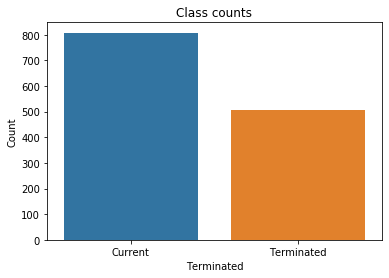

In [48]:
# Terminated vs. Not

pos = emp_mark[emp_mark['Terminated'] == 1].shape[0]
neg = emp_mark[emp_mark['Terminated'] == 0].shape[0]

print("Positive examples = {}".format(pos))
print("Negative examples = {}".format(neg))
print("Proportion of positive to negative examples = {:.2f}%".format((pos / neg) * 100))

import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

sns.countplot(emp_mark['Terminated'])
plt.xticks((0, 1), ['Current', 'Terminated'])
plt.xlabel('Terminated')
plt.ylabel("Count")
plt.title("Class counts");

Although we have a slight bias towards current employees (which look a little bit higher than expected), the division is relatively evenly split, and as such we will not be upsampling the terminated examples. It would be preferable to have more records for training, but we are not able to create good synthetic records in this case.

# Modeling

## Models to be Used

For this analysis we will be using a couple individual models and comparing their performance on a couple metrics. The primary comparisons will be done using the ROC curve, the AUC of the ROC, and accuracy metrics. We may also look at the _f1-score_ as Mr. Daburra did in his post, but since our data set is not as imblanced it may not be as valuable.

The models we will be using are:
* Random Forest
* KNN
* SVM
* Naive Bayes

## Training and Testing Data

For our model building we will be using 80% of randomly sampled records for training our models and 20% for testing. These will be split using Scikit-Learn, as will our models.

In [49]:
#Split data into train and test

from sklearn.model_selection import train_test_split

X = pd.DataFrame(emp_mark.iloc[:, emp_mark.columns != 'Terminated'])
y = pd.DataFrame(emp_mark.iloc[:, emp_mark.columns == 'Terminated'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 207311)

## PCA (Principle Component Analysis)

For our analysis, we desire a very simple to explain model (or at least as simple as we can achieve). For this reason, we will not be using PCA to simplify our data. We will also be using the encoded data to retain our categorical data and to separate them into individual components to make them more explainable to management.

## Random Forest Model

Our first model will be a Random Forest model from Scikit-Learn. This model uses a multitude of decision trees run on the training data to provide a method of "voting" for the most effective decision trees. This model is a good start as it does not require massive amounts of data to run these trees as they run with replacement, and it can find novel connections by altering some of the parameters such as the number of features to use at each step in the tree.

In [50]:
#Random Forest Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

forest = RandomForestClassifier(random_state = 207311)

for_mod = forest.fit(X_train, y_train)

Random Forest Accuracy = 0.9809885931558935


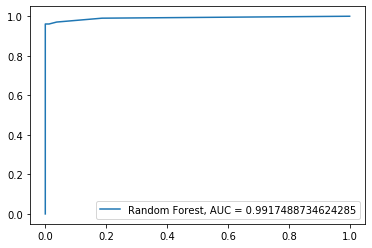

In [51]:
#AUC ROC and accuracy

from sklearn import metrics

for_preds = forest.predict(X_test)
for_probs = forest.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, for_probs)
for_auc = metrics.roc_auc_score(y_test, for_probs)

for_acc = metrics.accuracy_score(y_test, for_preds)

print('Random Forest Accuracy = ' + str(for_acc))

plt.plot(fpr, tpr, label = 'Random Forest, AUC = ' + str(for_auc))
plt.legend(loc = 4)
plt.show()

Here we see that the model actually performs incredibly well! However, there is a catch, as we can see when we look at the feature importance that results from this model.

In [52]:
#Create feature importance table

for_importance = pd.DataFrame(forest.feature_importances_,
                                index = X.columns,
                                columns = ['Importance']
                                ).sort_values('Importance', ascending = False)

for_importance.head(10)

,Importance
Length of Employment,0.248106
DJI,0.228286
CPI,0.100621
Building Code_MAIN,0.031707
Floor Code_SHOP,0.027784
Building Code_1300,0.027760
Job Title_Probationary Employee,0.026036
Building Code_GR,0.024548
Department_D040,0.013726
Manager No__3092,0.011651


The top feature of this model is the DJI! While this makes some intuitive sense that market would impact unemployment, it exposes a major issue with the DJI and CPI figures: all current employees have the same value. This means that all current employees are incredibly easy to identify as DJI and CPI are the exact same for all those employees that are current.

Unfortunately, this means we must remove these values and run the model again as we effectively labelled the terminated and current with market factors. With this in place it would not provide a good way to predict turnover.

In [53]:
#Create new data set without DJI and CPI

emp_mark_2 = emp_mark.drop(columns = ['DJI', 'CPI'])

In [54]:
#Split data into train and test for the second time

X_2 = pd.DataFrame(emp_mark_2.iloc[:, emp_mark_2.columns != 'Terminated'])
y_2 = pd.DataFrame(emp_mark_2.iloc[:, emp_mark_2.columns == 'Terminated'])

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size = 0.2, random_state = 207311)

In [55]:
#Random Forest Model take 2

forest_2 = RandomForestClassifier(random_state = 207311)

for_mod_2 = forest_2.fit(X_train_2, y_train_2)

Random Forest Accuracy = 0.9467680608365019


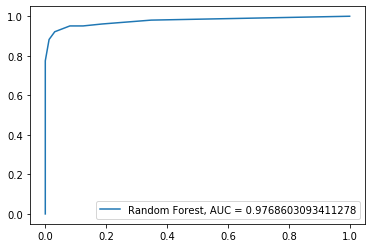

In [56]:
#AUC ROC and accuracy take 2

for_preds_2 = forest_2.predict(X_test_2)
for_probs_2 = forest_2.predict_proba(X_test_2)[:,1]
fpr_2, tpr_2, _ = metrics.roc_curve(y_test_2, for_probs_2)
for_auc_2 = metrics.roc_auc_score(y_test_2, for_probs_2)

for_acc_2 = metrics.accuracy_score(y_test_2, for_preds_2)

print('Random Forest Accuracy = ' + str(for_acc_2))

plt.plot(fpr_2, tpr_2, label = 'Random Forest, AUC = ' + str(for_auc_2))
plt.legend(loc = 4)
plt.show()

In [57]:
#Create feature importance table take 2

for_importance_2 = pd.DataFrame(forest_2.feature_importances_,
                                index = X_2.columns,
                                columns = ['Importance']
                                ).sort_values('Importance', ascending = False)

for_importance_2.head(10)

,Importance
Length of Employment,0.203943
Floor Code_SHOP,0.077666
Building Code_MAIN,0.072097
Building Code_1300,0.053954
Building Code_GR,0.049553
Building Code_1300SHARE,0.022729
Manager No__3092,0.021974
Manager No__59,0.017827
Job Title_Casual,0.016929
Department_D050,0.016680


With these two values removed, we see that the model still performs very well and that the importance features are very easy to interpret. From a business perspective, the length of employment playing a big role makes sense (retirment for instance, long time at the company and terminated). Additionally, the floor code indicates the type of work, so having 'SHOP' correlate makes sense as the shop (production) employees see more turnover in times of economic downturn and seasonal work. Building codes make a little less sense, as we no longer own the 'MAIN' facility, so those records will make it more complicated to predict new employees/current employees that may leave.

It is also intriguing to see the manager ID's of 3092 and 59 being so impactful. These managers happen to be our current and former Production Managers. It seems that this might also be connected with the Floor Code field in a sense.

## K-Nearest Neighbors Model

Our next model is that of the K-Nearest Neighbors. This method uses the distance between points on a hyperplane to determine relative 'closeness' between classes. This method will be using the same training and testing data, and we will try a few different values for the 'n_neighbors' parameter.

In [58]:
#KNN Model

from sklearn.neighbors import KNeighborsClassifier

knn1 = KNeighborsClassifier(n_neighbors = 1)
knn3 = KNeighborsClassifier(n_neighbors = 3)
knn5 = KNeighborsClassifier(n_neighbors = 5)
knn10 = KNeighborsClassifier(n_neighbors = 10)

emp_knn1 = knn1.fit(X_train_2, y_train_2)
emp_knn3 = knn3.fit(X_train_2, y_train_2)
emp_knn5 = knn5.fit(X_train_2, y_train_2)
emp_knn10 = knn10.fit(X_train_2, y_train_2)

KNN n = 1 Accuracy = 0.9429657794676806
KNN n = 3 Accuracy = 0.9391634980988594
KNN n = 5 Accuracy = 0.9429657794676806
KNN n = 10 Accuracy = 0.9391634980988594


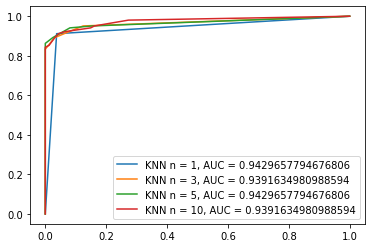

In [59]:
#AUC ROC for KNN

emp_knn1_preds = emp_knn1.predict(X_test_2)
emp_knn1_probs = emp_knn1.predict_proba(X_test_2)[:,1]
fpr_knn1, tpr_knn1, _ = metrics.roc_curve(y_test_2, emp_knn1_probs)
knn1_auc = metrics.roc_auc_score(y_test_2, emp_knn1_probs)
knn1_acc = metrics.accuracy_score(y_test_2, emp_knn1_preds)
print('KNN n = 1 Accuracy = ' + str(knn1_acc))

#Wanted to make the repition function based, but did not have the expertise/time

emp_knn3_preds = emp_knn3.predict(X_test_2)
emp_knn3_probs = emp_knn3.predict_proba(X_test_2)[:,1]
fpr_knn3, tpr_knn3, _ = metrics.roc_curve(y_test_2, emp_knn3_probs)
knn3_auc = metrics.roc_auc_score(y_test_2, emp_knn3_probs)
knn3_acc = metrics.accuracy_score(y_test_2, emp_knn3_preds)
print('KNN n = 3 Accuracy = ' + str(knn3_acc))

emp_knn5_preds = emp_knn5.predict(X_test_2)
emp_knn5_probs = emp_knn5.predict_proba(X_test_2)[:,1]
fpr_knn5, tpr_knn5, _ = metrics.roc_curve(y_test_2, emp_knn5_probs)
knn5_auc = metrics.roc_auc_score(y_test_2, emp_knn5_probs)
knn5_acc = metrics.accuracy_score(y_test_2, emp_knn5_preds)
print('KNN n = 5 Accuracy = ' + str(knn5_acc))

emp_knn10_preds = emp_knn10.predict(X_test_2)
emp_knn10_probs = emp_knn10.predict_proba(X_test_2)[:,1]
fpr_knn10, tpr_knn10, _ = metrics.roc_curve(y_test_2, emp_knn10_probs)
knn10_auc = metrics.roc_auc_score(y_test_2, emp_knn10_probs)
knn10_acc = metrics.accuracy_score(y_test_2, emp_knn10_preds)
print('KNN n = 10 Accuracy = ' + str(knn10_acc))

plt.plot(fpr_knn1, tpr_knn1, label = 'KNN n = 1, AUC = ' + str(knn1_acc))
plt.plot(fpr_knn3, tpr_knn3, label = 'KNN n = 3, AUC = ' + str(knn3_acc))
plt.plot(fpr_knn5, tpr_knn5, label = 'KNN n = 5, AUC = ' + str(knn5_acc))
plt.plot(fpr_knn10, tpr_knn10, label = 'KNN n = 10, AUC = ' + str(knn10_acc))
plt.legend(loc = 4)
plt.show()

Looking at our ROC graph, we can see that all models performed very well, and the accuracies were very close. Because of this, we will take the fastest to the top left of the graph (in this case n = 5). This is for 2 reasons: it was slightly faster to the correct classification, and it is tied for the highest accuracy.

## SVM Model

SVM (Support Vector Machine) is a model that excels in high-dimensionality problems and those problems which have more dimensions than samples. For our data set, this is exactly the case as we have many dummied categories that expand our data set into a very wide table, with less samples than dimensions.

We will be using the hyperparameters from the article mentioned earlier (the author captured these from a "Penn Machine Learning Benchmark 165" paper). In this case: 
* C = 0.01
* Gamma = 0.1
* Kernel = poly
* Degree = 5
* Coef0 = 10

In [60]:
from sklearn import svm

svm = svm.SVC(probability = True)

emp_svm = svm.fit(X_train_2, y_train_2)

SVM Accuracy = 0.8783269961977186


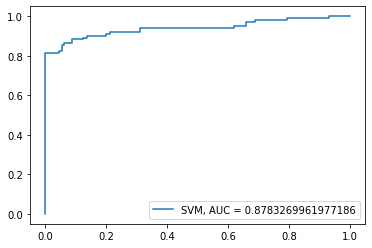

In [61]:
#AUC ROC and accuracy

svm_preds = emp_svm.predict(X_test_2)
svm_probs = emp_svm.predict_proba(X_test_2)[:,1]
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_test_2, svm_probs)
svm_auc = metrics.roc_auc_score(y_test_2, svm_probs)

svm_acc = metrics.accuracy_score(y_test_2, svm_preds)

print('SVM Accuracy = ' + str(svm_acc))

plt.plot(fpr_svm, tpr_svm, label = 'SVM, AUC = ' + str(svm_acc))
plt.legend(loc = 4)
plt.show()

Here we see that our SVM model was actually the worst performer on our data set. It had both the lowest accuracy and the lowest AUC. The curve is actually very telling as it levels our very quickly then takes a long time to begin correcting itself. This model is not a good contender for further exploration.

## Naive Bayes Model

Lastly we will be looking at the Gaussian version of Naive Bayes. This method is of interest as it makes the "naive" assumption that every pair of features is independent, which is almost certainly incorrect in this data set (such as the example where we have the Floor Code and Manager ID being intertwined). This is still of interest and worthwile exploring for our classification problem.

In [62]:
#Naive Bayes Model

from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

emp_nb = nb.fit(X_train_2, y_train_2)

Naives Bayes Accuracy = 0.7908745247148289


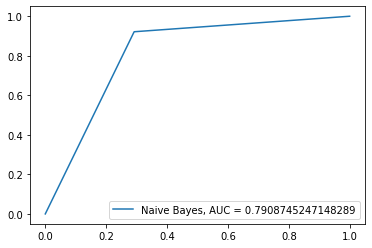

In [63]:
#AUC ROC and accuracy take 2

nb_preds = emp_nb.predict(X_test_2)
nb_probs = emp_nb.predict_proba(X_test_2)[:,1]
fpr_nb, tpr_nb, _ = metrics.roc_curve(y_test_2, nb_probs)
nb_auc = metrics.roc_auc_score(y_test_2, nb_probs)

nb_acc = metrics.accuracy_score(y_test_2, nb_preds)

print('Naives Bayes Accuracy = ' + str(nb_acc))

plt.plot(fpr_nb, tpr_nb, label = 'Naive Bayes, AUC = ' + str(nb_acc))
plt.legend(loc = 4)
plt.show()

Our last model happens to also be the worst performing according to our AUC criteria and our accuracy measurement. It would appear that this simplified model was not suited to our task, and has fallen behind (significantly) our other models.

# Conclusions

## Dropping Production Metrics Component (for now)

Currently, our production system (and thus the supporting systems) are stretched incredibly thin, and as such have very little interest in including production vs. turnover metrics. Given the lack of interest, for now I will be dropping this component and working towards sharing the models for predicting employee turnover. I intend to expand this project further down the road when production is more stable by calculating turnover per month as a proportion of active employees, then using some time series analysis techinques to determine if there is a noticeable impact on our production metrics, or if we see very little change due to turnover and are more impacted by factors such as DJI, CPI, or seasonal effects.

Given the effort in collecting this data I felt it relevant to retain here as a repository for further analysis. Expanding upon this Jupyter notebook should be far easier then restarting the entire project.

## Model Selection

### Accuracy

In order to determine which model is best for our use case, we must compare the accuracy value for each. Although AUC is of great importance, if the model cannot accurately predict on testing data then it is harder to recommend to our HR group.

In [64]:
# Accuracy Comparison

print('Random Forest Accuracy = ' + str(for_acc_2))
print('KNN n = 1 Accuracy = ' + str(knn1_acc))
print('KNN n = 3 Accuracy = ' + str(knn3_acc))
print('KNN n = 5 Accuracy = ' + str(knn5_acc))
print('KNN n = 10 Accuracy = ' + str(knn10_acc))
print('SVM Accuracy = ' + str(svm_acc))
print('Naives Bayes Accuracy = ' + str(nb_acc))

Random Forest Accuracy = 0.9467680608365019
KNN n = 1 Accuracy = 0.9429657794676806
KNN n = 3 Accuracy = 0.9391634980988594
KNN n = 5 Accuracy = 0.9429657794676806
KNN n = 10 Accuracy = 0.9391634980988594
SVM Accuracy = 0.8783269961977186
Naives Bayes Accuracy = 0.7908745247148289


Looking at our metrics across all models, we can see that our Random Forest and KNN models were our best performers. In fact, they are all within 0.07 of each other. As such, we will only consider these models as viable, even though we will include all models in our analysis.

### ROC

Our next component to analyze is the ROC and its related AUC values.

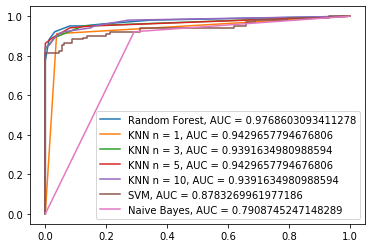

In [65]:
#Plot all ROC

plt.plot(fpr_2, tpr_2, label = 'Random Forest, AUC = ' + str(for_auc_2))
plt.plot(fpr_knn1, tpr_knn1, label = 'KNN n = 1, AUC = ' + str(knn1_acc))
plt.plot(fpr_knn3, tpr_knn3, label = 'KNN n = 3, AUC = ' + str(knn3_acc))
plt.plot(fpr_knn5, tpr_knn5, label = 'KNN n = 5, AUC = ' + str(knn5_acc))
plt.plot(fpr_knn10, tpr_knn10, label = 'KNN n = 10, AUC = ' + str(knn10_acc))
plt.plot(fpr_svm, tpr_svm, label = 'SVM, AUC = ' + str(svm_acc))
plt.plot(fpr_nb, tpr_nb, label = 'Naive Bayes, AUC = ' + str(nb_acc))
plt.legend(loc = 4)
plt.show()

Our ROC graph does not give a clear picture as to which model is best, in fact it appears that most of the models perform fairly well other than our Naive Bayes. However, we can see that a couple models do have some big performance gains when looking at AUC. Random Forest and KNN both appear to be strong contenders just as they were in accuracy (which is intuitive).

### Which model is best?

Given our conclusions in terms of accuracy, ROC, and AUC, it is clear that our frontrunners are Random Forest and KNN (specifically n = 5). With these models performing very similarly, it could be left up to preference, save for the fact that a Random Forest model is far easier to explain to management. 

Since we must consider user buy-in and the benefits of showing a simpler model, which is also easier to implement, I have come to the conclusion that our Random Forest model is the superior model for our data set.

### What next?

Now that we have a high performing model and some features to use to describe its makeup, meeting with our HR team and discussing ways to mitigate employee turnover for those employees which are at a higher risk will be the next task. Once there is some buy-in, I can move forward to comparing turnover to production metrics in order to give a bit more reason for our operations team to invest in keeping certain employees, or mitigating turnover risk. 

### What takeaways should management have?

First and foremost: our biggest determiner of turnover is length of employment. This makes some intuitive sense (long term employees retire out, temporary or probationary employees are retained for shorter periods), however, we can now use this knowledge to plan better for potential retirement plans and begin the discussions earlier, or revamp the method in which we on-board seasonal/temporary workers.

Next is that employees in our 1210 facility (building code) are less likely to be terminated. This may be in large part due to the smaller crew that works in this location. 

Our employee's floor code is also very important: SHOP workers turnover far more frequently than office workers. This may again be due to the temporary workers that we onboard during periods of high demand. A method to combat this could be to prepare an overtime schedule well in advance if we do not wish to expend resources onboarding, training, and then releasing temporary workers.

Lastly, there are managers with far higher turnover than others. In general these managers are production related, and as we discussed there is more turnover in production. However, if certain managers are far higher than others (such as our production manager, which leads the assembly group), then it could be worthwile to determine why such groups have higher turnover. Perhaps management style, interpersonal conflicts, or working procedures lead to an increase in individual groups.

# Open Topics and Questions

There are still several questions that I would like to tackle post project:
* How do our workers' salaries compare to the national average?
* Does salary play a critical role in turnover?
* How does turnover affect on-time shipments and on-time productions?
* Which managerial position experience the highest impact on turnover?

These questions will have to be addressed at a later date once more interest has been found for such an analysis.

In addition, I have some open points of improvement:
* Increase data set size
* Implement a system for notifying HR of an at risk employee
* Create a distribution of the likelihood of an employee leaving
* Determine which employees are worth expending additional resources in order to retain

Again, for the time being it must be postponed, but I believe in time people will become more interested in such metrics, especially if we continue to expand our workforce (which is unlikely in the short term during the COVID-19 crisis, but is likely directly post-crisis).